In [238]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob
import seaborn as sns
from matplotlib import ticker

In [133]:
sim_names = ['transition_state', 'reactant']
features = ['alpha', 'contact_filtered', 'phi_psi']
feature_names = [r'$C_{\alpha}$ dihedral', r'$C_{\alpha}-C_{\alpha}$ contact', r'$\phi, \psi$ dihedral']
n_trials = 5
n_its = 5

In [236]:
lags = (np.arange(10, 50)).astype(int)
cols = sns.color_palette('colorblind')

def get_timescales(its):
    mean = np.mean(its, axis=0)
    lb = np.quantile(its, q=0.025, axis=0)
    ub = np.quantile(its, q=0.975, axis=0)
    return (mean, lb, ub)

def get_ratios(its):
    ratios = its[:, :, :-1]/its[:, :, 1:]
    mean = np.mean(ratios, axis=0)
    lb = np.quantile(ratios, q=0.025, axis=0)
    ub = np.quantile(ratios, q=0.975, axis=0)
    return (mean, lb, ub)


def plot_timescales(ax, its):
    mean_its, lb_its, ub_its = get_timescales(result[1])
    for k in range(mean_its.shape[-1]):
        ax.plot(lags, mean_its[:, k], label=r'$t_{{{}}}$'.format(k+2))
        ax.fill_between(lags, lb_its[:, k], ub_its[:, k], alpha=0.2)

        
def plot_ratios(ax, its, lag_ix=-1):
    mean_its, lb_its, ub_its = get_ratios(its)
    for k in range(mean_its.shape[-1]):
        yerr = [[mean_its[lag_ix, k]-lb_its[lag_ix, k]], [ub_its[lag_ix, k]-mean_its[lag_ix, k]]]
        ax.errorbar(int(k+2), mean_its[lag_ix, k], yerr=yerr, label=r'$t_{{{}}}/t_{{{}}}$'.format(k+2, k+3), marker='o', color=cols[0])
        
        
def get_file_paths(sim_name, feature):
    glob_path = f'lag_determination/{sim_name}_{feature}_*.p'
    file_paths = glob(glob_path)
    return file_paths

def hp_label(hps):
    msg = rf"$\tau$: {hps['vamp']['lag']/10} ns, $m$: {hps['vamp']['dim']}, $n$: {hps['cluster_kmeans']['k']}"
    return msg

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


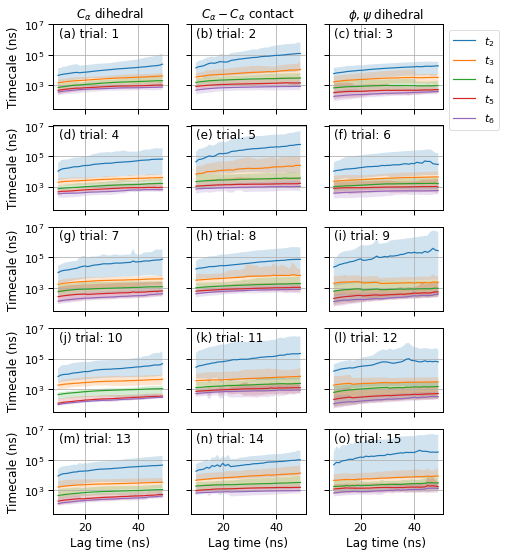

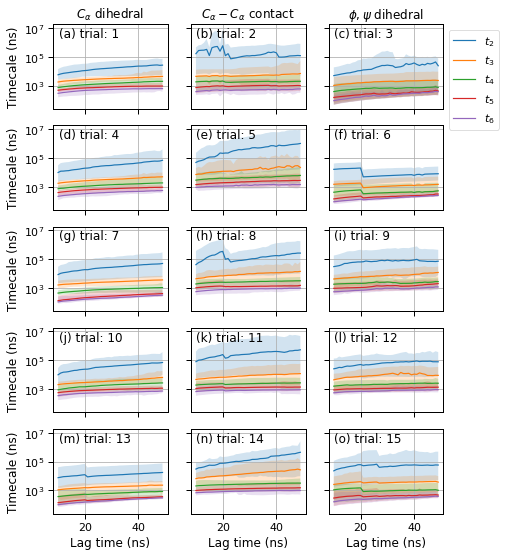

In [241]:

for sim_name in sim_names:
    letters = list('abcdefghijklmnopqrstuvwxyz')

    with sns.plotting_context('paper', font_scale=1.25):
        fig, axes = plt.subplots(n_trials, len(features), figsize=(7, 9), sharex=True, sharey=True)

        for j, feature in enumerate(features):

            file_paths = get_file_paths(sim_name, feature)

            for i, trial_path in enumerate(file_paths):

                result = pickle.load(open(trial_path, 'rb'))
                plot_timescales(axes[i, j], result[1])
                trial_num = i*len(features) + j
                axes[i, j].annotate(xy=(0.05, 0.85), xycoords='axes fraction', text=f"({letters[trial_num]}) trial: {trial_num+1}")
                axes[i, j].set_yscale('log')
                axes[i, j].grid()
                if j == 0:
                    axes[i, j].set_ylabel('Timecale (ns)')
                if i == n_trials-1:
                    axes[i, j].set_xlabel('Lag time (ns)')
                if i == 0:
                    axes[i, j].set_title(f'{feature_names[j]}')
            axes[0, -1].legend(bbox_to_anchor=(1, 1))
        plt.savefig(f"figures/{sim_name}_timescale_plots.png")

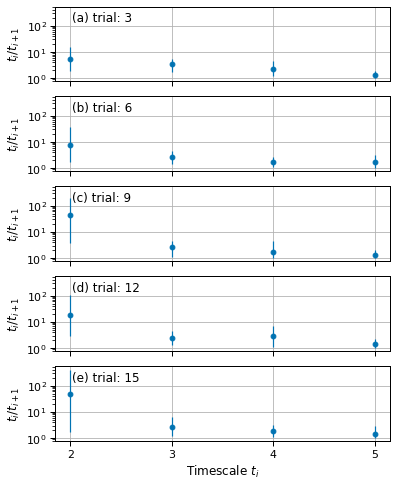

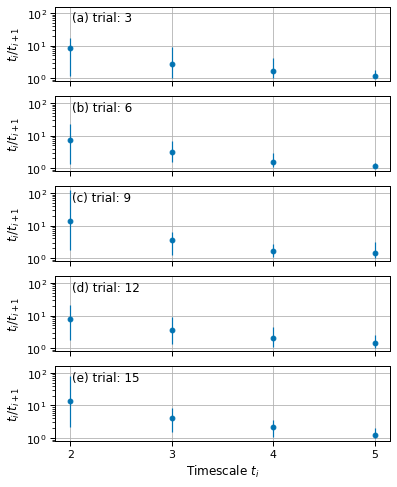

In [248]:
lag = 40
lag_ix = np.where(lags==lag)[0][0]
new_features = [features[-1]]
new_feature_names = [feature_names[-1]]
for sim_name in sim_names:
    letters = list('abcdefghijklmnopqrstuvwxyz')

    with sns.plotting_context('paper', font_scale=1.25):
        fig, axes = plt.subplots(n_trials, len(new_features), figsize=(6, 8), sharex=True, sharey=True)
        axes = axes.reshape(-1, 1)
        for j, feature in enumerate(new_features):

            file_paths = get_file_paths(sim_name, feature)

            for i, trial_path in enumerate(file_paths):

                result = pickle.load(open(trial_path, 'rb'))
                plot_ratios(axes[i, j], result[1], lag_ix=lag_ix)
                
                trial_num = i*(len(features)) + j + 2 # to match with the above figure
                axes[i, j].annotate(xy=(0.05, 0.8), xycoords='axes fraction', text=f"({letters[i*len(new_features) + j]}) trial: {trial_num+1}")
                axes[i, j].set_yscale('log')
                axes[i, j].xaxis.set_major_locator(ticker.MultipleLocator(1))
                axes[i, j].grid()
                if j == 0:
                    axes[i, j].set_ylabel('$t_{i}/t_{i+1}$')
                if i == n_trials-1:
                    axes[i, j].set_xlabel('Timescale $t_{i}$')
                
                
#             axes[0, -1].legend(bbox_to_anchor=(1, 1))
        plt.savefig(f"figures/{sim_name}_{feature}_timescale_ratio_plots.png")